## AUROC spaced-kmer vs NB distance (Figure S6)

In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
import pickle
import seaborn as sns
from Bio import SeqIO
from os.path import isfile, join
from itertools import compress
import itertools
from scipy.stats import nbinom
import matplotlib

#### See auroc_kmer_vs_bmf.ipynb for train/test split code

In [2]:
def fasta_length(file_name):
    input_seq_iterator = SeqIO.parse(file_name, "fasta")
    return len([record.seq for record in input_seq_iterator])

In [3]:
def read_predictions(pred_file):
    pred = np.loadtxt(pred_file)
    return pred

In [4]:
file_table = pd.read_csv('../../../cbscratch/selex_taipale/ps_and_bg_file_table_first_and_last.txt', sep='\t', header=None)
fasta_path = '../../../cbscratch/selex_taipale/fasta_split_first_and_last/'
count_table = []
for i in range(len(file_table)):
    factor = file_table.iloc[i,0]
    ps_file = os.path.join(fasta_path, f'{factor}_test_ps.fasta')
    ps_no = fasta_length(ps_file)
    
    bg_file = os.path.join(fasta_path, f'{factor}_test_bg.fasta')
    bg_no = fasta_length(bg_file)
    
    count_table.append([factor, ps_no, bg_no])

## Compare the effet of max_iterations

In [5]:
nb1000_path = 'param/selex_nodist0_1000/split_selex_cs3/'
nb1500_path = 'param/selex_nodist0_1500/split_selex_cs3/'

In [6]:
def comp_auc(file, y_true):
    if os.path.isfile(file):
        y_comp = read_predictions(file)
        auc_comp = roc_auc_score(y_true, y_comp)
    else:
        print(f'predictions not found (runtime error)')
        auc_comp = np.nan
    return auc_comp


auc_list = []

for i in range(len(count_table)):
    
    factor, ps_no, bg_no = count_table[i]
    
    fpr = []
    tpr = []

    nb1000_file = os.path.join(nb1000_path, f'{factor}.predictions')
    nb1500_file = os.path.join(nb1500_path, f'{factor}.predictions')
    
    y_true = np.concatenate([np.ones(ps_no), np.zeros(bg_no)])

    auc_nb10 = comp_auc(nb1000_file, y_true)
    auc_nb15 = comp_auc(nb1500_file, y_true)

    auc_list.append([auc_nb10, auc_nb15])  

In [8]:
plotting_dir = 'max_iter'

datasets = ['1000 iterations', '1500 iterations']
factors = [c[0] for c in count_table]

metric_df = pd.DataFrame(auc_list, columns=datasets)
metric_df['factors'] = [c.split('-')[0] for c in factors]
factors_unique = []
metric_by_factor = {}
for label, df in metric_df.groupby('factors'):
    factors_unique.append(label)
    values = df.replace(0, np.NaN).mean()
    metric_by_factor[label] = values

metric_by_factor = pd.DataFrame(metric_by_factor).T.loc[:,datasets].values
metric_by_factor = np.array(metric_by_factor)

## Compare iterations

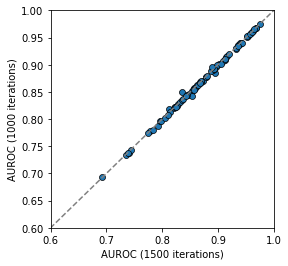

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.scatter(metric_by_factor[:,1],metric_by_factor[:,0], linewidths=0.7, edgecolor='black')
_ = ax.set_xlim(0.6,1)
_ = ax.set_ylim(0.6,1)
_ = ax.plot([0,1],[0,1],ls='--',color='grey')
_ = ax.set_xlabel(f'AUROC ({datasets[1]})')
_ = ax.set_ylabel(f'AUROC ({datasets[0]})')
            
plt.savefig(os.path.join(plotting_dir,'1500vs1000.pdf'), bbox_inches='tight')